In [18]:
import numpy as np
import networkx as nx
import os
import sys
from gensim.models import KeyedVectors
from sklearn.metrics import RocCurveDisplay, classification_report, roc_curve, roc_auc_score
sys.path.append(os.path.join(os.path.dirname(os.path.abspath('')), 'scripts'))
# help me with idea why second name does't import
from train_test_split import sparse_to_tuple #, make_split
from get_graph import get_digraph

In [2]:
import numpy as np
import networkx as nx
import scipy.sparse as sp

def make_split(adj, test_frac=.1, val_frac=.05, prevent_disconnect=True, verbose=False):
    if verbose == True:
        print('preprocessing...')

    # Remove diagonal elements
    adj = adj - sp.dia_matrix((adj.diagonal()[np.newaxis, :], [0]), shape=adj.shape)
    adj.eliminate_zeros()
    # Check that diag is zero:
    assert np.diag(adj.todense()).sum() == 0

    g = nx.from_scipy_sparse_array(adj)
    orig_num_cc = nx.number_connected_components(g)

    adj_triu = sp.triu(adj) # upper triangular portion of adj matrix
    adj_tuple = sparse_to_tuple(adj_triu) # (coords, values, shape), edges only 1 way
    edges = adj_tuple[0] # all edges, listed only once (not 2 ways)
    # edges_all = sparse_to_tuple(adj)[0] # ALL edges (includes both ways)
    num_test = int(np.floor(edges.shape[0] * test_frac)) # controls how large the test set should be
    num_val = int(np.floor(edges.shape[0] * val_frac)) # controls how alrge the validation set should be

    # Store edges in list of ordered tuples (node1, node2) where node1 < node2
    edge_tuples = [(min(edge[0], edge[1]), max(edge[0], edge[1])) for edge in edges]
    all_edge_tuples = set(edge_tuples)
    train_edges = set(edge_tuples) # initialize train_edges to have all edges
    test_edges = set()
    val_edges = set()

    if verbose == True:
        print('generating test/val sets...')

    # Iterate over shuffled edges, add to train/val sets
    np.random.shuffle(edge_tuples)
    for edge in edge_tuples:
        node1 = edge[0]
        node2 = edge[1]

        # If removing edge would disconnect a connected component, backtrack and move on
        g.remove_edge(node1, node2)
        if prevent_disconnect == True:
            if nx.number_connected_components(g) > orig_num_cc:
                g.add_edge(node1, node2)
                continue

        # Fill test_edges first
        if len(test_edges) < num_test:
            test_edges.add(edge)
            train_edges.remove(edge)

        # Then, fill val_edges
        elif len(val_edges) < num_val:
            val_edges.add(edge)
            train_edges.remove(edge)

        # Both edge lists full --> break loop
        elif len(test_edges) == num_test and len(val_edges) == num_val:
            break

    if (len(val_edges) < num_val or len(test_edges) < num_test):
        print("WARNING: not enough removable edges to perform full train-test split!")
        print("Num. (test, val) edges requested: (", num_test, ", ", num_val, ")")
        print("Num. (test, val) edges returned: (", len(test_edges), ", ", len(val_edges), ")")

    if prevent_disconnect == True:
        assert nx.number_connected_components(g) == orig_num_cc

    if verbose == True:
        print('creating false test edges...')

    test_edges_false = set()
    while len(test_edges_false) < num_test:
        idx_i = np.random.randint(0, adj.shape[0])
        idx_j = np.random.randint(0, adj.shape[0])
        if idx_i == idx_j:
            continue

        false_edge = (min(idx_i, idx_j), max(idx_i, idx_j))

        # Make sure false_edge not an actual edge, and not a repeat
        if false_edge in all_edge_tuples:
            continue
        if false_edge in test_edges_false:
            continue

        test_edges_false.add(false_edge)

    if verbose == True:
        print('creating false val edges...')

    val_edges_false = set()
    while len(val_edges_false) < num_val:
        idx_i = np.random.randint(0, adj.shape[0])
        idx_j = np.random.randint(0, adj.shape[0])
        if idx_i == idx_j:
            continue

        false_edge = (min(idx_i, idx_j), max(idx_i, idx_j))

        # Make sure false_edge in not an actual edge, not in test_edges_false, not a repeat
        if false_edge in all_edge_tuples or \
            false_edge in test_edges_false or \
            false_edge in val_edges_false:
            continue

        val_edges_false.add(false_edge)

    if verbose == True:
        print('creating false train edges...')

    train_edges_false = set()
    while len(train_edges_false) < len(train_edges):
        idx_i = np.random.randint(0, adj.shape[0])
        idx_j = np.random.randint(0, adj.shape[0])
        if idx_i == idx_j:
            continue

        false_edge = (min(idx_i, idx_j), max(idx_i, idx_j))

        # Make sure false_edge in not an actual edge, not in test_edges_false,
            # not in val_edges_false, not a repeat
        if false_edge in all_edge_tuples or \
            false_edge in test_edges_false or \
            false_edge in val_edges_false or \
            false_edge in train_edges_false:
            continue

        train_edges_false.add(false_edge)

    if verbose == True:
        print('final checks for disjointness...')

    # assert: false_edges are actually false (not in all_edge_tuples)
    assert test_edges_false.isdisjoint(all_edge_tuples)
    assert val_edges_false.isdisjoint(all_edge_tuples)
    assert train_edges_false.isdisjoint(all_edge_tuples)

    # assert: test, val, train false edges disjoint
    assert test_edges_false.isdisjoint(val_edges_false)
    assert test_edges_false.isdisjoint(train_edges_false)
    assert val_edges_false.isdisjoint(train_edges_false)

    # assert: test, val, train positive edges disjoint
    assert val_edges.isdisjoint(train_edges)
    assert test_edges.isdisjoint(train_edges)
    assert val_edges.isdisjoint(test_edges)

    if verbose == True:
        print('creating adj_train...')

    # Re-build adj matrix using remaining graph
    adj_train = nx.adjacency_matrix(g)

    # Convert edge-lists to numpy arrays
    train_edges = np.array([list(edge_tuple) for edge_tuple in train_edges])
    train_edges_false = np.array([list(edge_tuple) for edge_tuple in train_edges_false])
    val_edges = np.array([list(edge_tuple) for edge_tuple in val_edges])
    val_edges_false = np.array([list(edge_tuple) for edge_tuple in val_edges_false])
    test_edges = np.array([list(edge_tuple) for edge_tuple in test_edges])
    test_edges_false = np.array([list(edge_tuple) for edge_tuple in test_edges_false])

    if verbose == True:
        print('Done with train-test split!')
        print('')

    # NOTE: these edge lists only contain single direction of edge!
    return adj_train, train_edges, train_edges_false, \
        val_edges, val_edges_false, test_edges, test_edges_false

In [3]:
def get_edge_embeddings(edge_list, embeddings):
    embs = []
    for edge in edge_list:
        node1 = edge[0]
        node2 = edge[1]
        emb1 = embeddings[node1]
        emb2 = embeddings[node2]
        edge_emb = np.multiply(emb1, emb2)
        embs.append(edge_emb)
    embs = np.array(embs)
    return embs

In [4]:
G = get_digraph()
np.random.seed(239) 
adj_sparse = nx.to_scipy_sparse_array(G)

In [5]:
adj_train, train_edges, train_edges_false, val_edges, val_edges_false, \
    test_edges, test_edges_false = make_split(adj_sparse, test_frac=.3, val_frac=.1, verbose=True)
G_train = nx.from_scipy_sparse_array(adj_train)

preprocessing...
generating test/val sets...
creating false test edges...
creating false val edges...
creating false train edges...
final checks for disjointness...
creating adj_train...
Done with train-test split!



In [10]:
embs_path = os.path.join(os.pardir, 'n2c_embs')
node_embeddings = KeyedVectors.load_word2vec_format(embs_path)

In [11]:
pos_train_edge_embs = get_edge_embeddings(train_edges, node_embeddings)
neg_train_edge_embs = get_edge_embeddings(train_edges_false, node_embeddings)

train_edge_embs = np.concatenate([pos_train_edge_embs, neg_train_edge_embs])
train_edge_labels = np.concatenate([np.ones(len(train_edges)), np.zeros(len(train_edges_false))])

In [12]:
pos_val_edge_embs = get_edge_embeddings(val_edges, node_embeddings)
neg_val_edge_embs = get_edge_embeddings(val_edges_false, node_embeddings)
val_edge_embs = np.concatenate([pos_val_edge_embs, neg_val_edge_embs])
val_edge_labels = np.concatenate([np.ones(len(val_edges)), np.zeros(len(val_edges_false))])

In [14]:
pos_test_edge_embs = get_edge_embeddings(test_edges, node_embeddings)
neg_test_edge_embs = get_edge_embeddings(test_edges_false, node_embeddings)
test_edge_embs = np.concatenate([pos_test_edge_embs, neg_test_edge_embs])
test_edge_labels = np.concatenate([np.ones(len(test_edges)), np.zeros(len(test_edges_false))])

In [15]:
from sklearn.linear_model import LogisticRegression
edge_classifier = LogisticRegression(random_state=0)
edge_classifier.fit(train_edge_embs, train_edge_labels)

LogisticRegression(random_state=0)

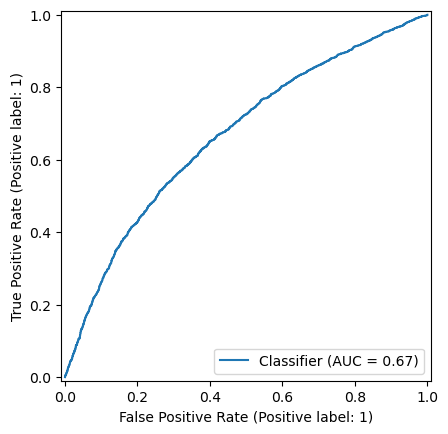

In [21]:
val_preds = edge_classifier.predict_proba(val_edge_embs)[:, 1]
RocCurveDisplay.from_predictions(val_edge_labels, val_preds)

In [24]:
print(classification_report(val_edge_labels, (val_preds >= 0.5)))

              precision    recall  f1-score   support

         0.0       0.64      0.57      0.60      3405
         1.0       0.61      0.67      0.64      3405

    accuracy                           0.62      6810
   macro avg       0.62      0.62      0.62      6810
weighted avg       0.62      0.62      0.62      6810

